imports


In [1]:
#francois
import os, sys

import copy

import numpy as np
from numpy import nan
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


import pandas as pd   # Excel but better.
pd.set_option('display.width', None)        # Automatically adjust the display width   <<<----- These two are courtesy of chatGPT. Finding param syntax is so long... Ffhyew.
pd.set_option('display.max_columns', None)  # Display all columns


import math as m # math stuff
import random as rd #always good to have
import matplotlib.pyplot as plt #plots.


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import functools as ft


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

np.random.seed(1234)
print("Import finished, \nhere's a random number:",rd.random(),"\nIf the number changed, the cell ran correctly. ")

Import finished, 
here's a random number: 0.8521941979195825 
If the number changed, the cell ran correctly. 


set directory

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

os.chdir("/content/gdrive//MyDrive/comp551")
print("The path is:", os.getcwd() )
print("All the files are: ",os.listdir())

Mounted at /content/gdrive/
The path is: /content/gdrive/MyDrive/comp551
All the files are:  ['NHANES_age_prediction.csv', 'breast_cancer_wisconsin.csv', 'bestk.png', 'roc_compareBancer.png']


Load data

In [3]:
#isabella

NHANESdata = pd.read_csv("NHANES_age_prediction.csv")
NHANESdata['age_group'].replace({'Adult': 0, 'Senior': 1}, inplace=True) # recode response to numerical

breastCancerData = pd.read_csv("breast_cancer_wisconsin.csv",na_values='?')
breastCancerData.columns = ['id','thickness','uniSize','uniShape','margAd','epiSize','bareNuc','blandChrom','normNuc','mitoses'
,'class']
breastCancerData['class'].replace({2: 0, 4: 1}, inplace=True) # recode response to numerical



Select the Breast Cancer dataset to work with and recode label variable

In [4]:
#isabella

data = breastCancerData
dataCopy = copy.deepcopy(data)
response = 'class' #set response. for NHANES it is 'age_group' for breastCancer it is 'class'

print("data type:",type(data))

print(data.describe,"\n") #overview of data
print(data.head(10))


data type: <class 'pandas.core.frame.DataFrame'>
<bound method NDFrame.describe of       id  thickness  uniSize  uniShape  margAd  epiSize  bareNuc  blandChrom  normNuc  mitoses  \
0      0          5        1         1       1        2      1.0           3        1        1   
1      1          5        4         4       5        7     10.0           3        2        1   
2      2          3        1         1       1        2      2.0           3        1        1   
3      3          6        8         8       1        3      4.0           3        7        1   
4      4          4        1         1       3        2      1.0           3        1        1   
..   ...        ...      ...       ...     ...      ...      ...         ...      ...      ...   
694  694          3        1         1       1        3      2.0           1        1        1   
695  695          2        1         1       1        2      1.0           1        1        1   
696  696          5       10       

impute missing points labeled '?'

In [5]:
#isabella

missing = data.isnull().sum

data[[]] = data[[]].replace('?',nan)

data.fillna(data.mean())

,id,thickness,uniSize,uniShape,margAd,epiSize,bareNuc,blandChrom,normNuc,mitoses,class
0,0,5,1,1,1,2,1.0,3,1,1,0
1,1,5,4,4,5,7,10.0,3,2,1,0
2,2,3,1,1,1,2,2.0,3,1,1,0
3,3,6,8,8,1,3,4.0,3,7,1,0
4,4,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
694,694,3,1,1,1,3,2.0,1,1,1,0
695,695,2,1,1,1,2,1.0,1,1,1,0
696,696,5,10,10,3,7,3.0,8,10,2,1
697,697,4,8,6,4,3,4.0,10,6,1,1


observe scale of all predictors

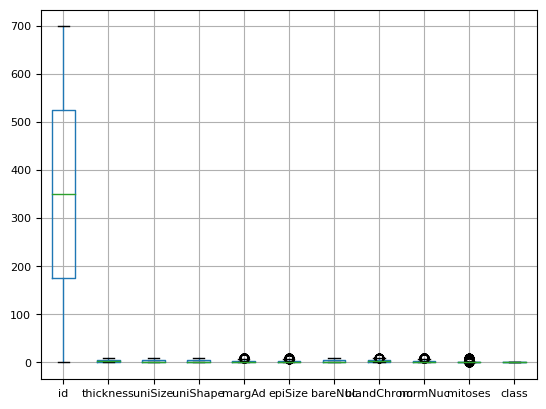

In [6]:
#isabella

#observe scale of all predictors

boxplot = data.boxplot(fontsize=8)



calculate parameter means, variances, correlations with label

In [7]:
#isabella

# analyze predictors

corr = data.corr()
responseCor = pd.DataFrame((corr[[response]])) #for NHANES column is age group, for breastCancer, column is class

params = list(data.columns.values)

means=[]
var=[]

for param in params: #get mean of each column
    val = data[param].mean()
    means.append(val)
means = pd.DataFrame(means)
names = list(responseCor.index)
means.index = names

var=[]
for param in params: #get mean of each column
    val = data[param].var()
    var.append(val)
var = pd.DataFrame(var)
names = list(responseCor.index)
var.index = names

responseCor.columns = ['corr']
responseCor = responseCor.sort_values(by = ['corr'])
print(responseCor)



                corr
id         -0.195603
mitoses     0.423170
epiSize     0.682785
margAd      0.696800
normNuc     0.712244
thickness   0.716001
blandChrom  0.756616
uniSize     0.817904
uniShape    0.818934
bareNuc     0.822696
class       1.000000


choose the two most important factors based on correlation with label

In [8]:
#isabella

corIndices = responseCor.index
impFact1 = corIndices[-2] #select the factors that correlated best with the label
impFact2 = corIndices[-3]

print(impFact1)
print(impFact2)

bareNuc
uniShape


re-scale  parameters if needed

In [9]:
#isabella

#if we need to rescale predictors

df = data.drop(impFact1,axis=1) #put factors on the same scale
df_norm = (df-df.min())/(df.max()-df.min())
df_norm = pd.concat((df_norm, data.bareNuc), 1) #update feature name

df1 = df_norm.drop(impFact2,axis=1)
df_norm1 = (df1-df1.min())/(df1.max()-df1.min())
df_norm1 = pd.concat((df_norm1, df_norm.uniShape), 1) #update feature name

df_norm1 = df_norm1.sample(frac=1) #shuffle data
print(df_norm1.head())

           id  thickness  uniSize  margAd   epiSize  blandChrom   normNuc  mitoses  class  \
341  0.488539   0.000000      0.0     0.0  0.111111    0.222222  0.000000      0.0    0.0   
532  0.762178   0.000000      0.0     0.0  0.000000    0.222222  0.000000      0.0    0.0   
687  0.984241   0.222222      0.0     0.0  0.111111    0.111111  0.222222      0.0    0.0   
83   0.118911   0.222222      0.0     0.0  0.111111    0.666667  0.000000      0.0    0.0   
428  0.613181   0.000000      0.0     0.0  0.111111    0.111111  0.000000      0.0    0.0   

      bareNuc  uniShape  
341  0.000000       0.0  
532  0.000000       0.0  
687  0.000000       0.0  
83   0.111111       0.0  
428  0.000000       0.0  


<ipython-input-9-7470d8af825f>:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_norm = pd.concat((df_norm, data.bareNuc), 1) #update feature name
<ipython-input-9-7470d8af825f>:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_norm1 = pd.concat((df_norm1, df_norm.uniShape), 1) #update feature name


x,y split

In [10]:
#isabella

# x y split on scaled factors

x, y = df_norm1[[impFact1,impFact2]], df_norm1[[response]]#slices columns most correlated with response variable

x,y = np.array(x), np.array(y)
x = x.astype(int)
y = y.astype(int)

In [11]:
#isabella

# x y split on non-scaled data (if scaling is not required)

x, y = data[[impFact1,impFact2]], data[[response]]#slices columns most correlated with response variable

x,y = np.array(x), np.array(y)

train, test split and plot data

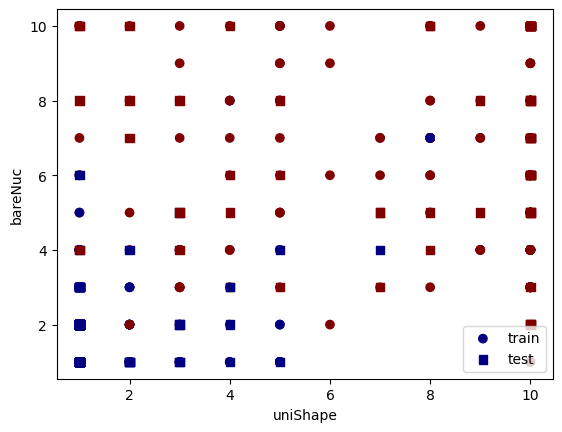

In [12]:
#isabella

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

#visualization of the data
plt.figure()
plt.xlabel(impFact2)
plt.ylabel(impFact1)

plt.scatter(x_train[:,0], x_train[:,1], c = y_train,cmap=plt.cm.jet, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c= y_test,cmap=plt.cm.jet, marker='s', label='test')

plt.legend()
plt.show()

KNN MODEL:

Define distance and accuracy functions

In [13]:
#isabella

# Distance functions

def euclidian(x1,x2):
  return(np.sqrt(np.sum((x1 - x2)**2, axis=-1)))

def manhattan(x1, x2):
  return(np.sum(abs(x1 - x2)))



define evaluation functions

In [14]:

#evaluate eccuracy

def evaluateAcc(true,predicted):

  accuracy = np.sum(predicted == true)/true.shape[0]
  print(accuracy)

#k-fold DT

def cross_validateDT(model, X_input, Y_output):
  kf = KFold(n_splits=5,random_state=1,shuffle=True)
  trueLabels = np.array([0] * X_input.shape[0])
  pred_scores = np.array([0.0]*X_input.shape[0])
  for train_index, test_index in kf.split(X_input):
    Y_output = Y_output.flatten()
    model.fit(X_input[train_index], Y_output[train_index])
    trueLabels = Y_output[test_index]
    prediction, probabilities = model.predict(X_input[test_index])
  return trueLabels, prediction

#k-fold KNN
def cross_validateKNN(model, X_input, Y_output):
   kf = KFold(n_splits=5,random_state=1,shuffle=True)
   trueLabels = np.array([0] * X_input.shape[0])
   pred_scores = np.array([0.0]*X_input.shape[0])
   for train_index, test_index in kf.split(X_input):
    model.fit(X_input[train_index], Y_output[train_index])
    trueLabels = Y_output[test_index]
    prediction,probability,knns = model.predict(X_input[test_index], bestK) #myK -> bestK // francois 2024-01-30, 15:35
   return trueLabels, prediction

define KNN model

In [15]:

#isabella
#Implement KNN

class KNN:

  def __init__(self):
      return

  def fit(self,x,y):
    self.x = x
    self.y = y
    self.C = np.max(y) + 1
    return self


  def predict(self, x_test,K,dist_fn=euclidian):
    numTest = x_test.shape[0]
    numTrain = x_train.shape[0]
    outputs = np.unique(y_train)
    predictions = []
    probabilities = []
    neighbors = []

    for val in range(1,numTest+1):
      x1 = x_test[(val-1):val,0:2] # takes test samples one by one
      distances = np.zeros(shape = (numTrain,1)) #empty list for this sample's distances
      probs = np.zeros(len(outputs)) #will calculate probability for each possible label
      for i in range(1,numTrain+1):
        x2 = x_train[i-1:i,0:2] # takes 1,2,...,n training samples
        newDist = np.array(dist_fn(x1,x2)) #calculate distance for i sample
        distances[i-1] = newDist #collect distance for sample i
      checkLabels = np.concatenate((x_train,y_train,np.array(distances)),axis=1)
      checkLabels = pd.DataFrame(checkLabels)
      checkLabels.columns = ['x1','x1','label','dist']
      knns = checkLabels.sort_values(by="dist",ascending=True).iloc[:K] # sort and pull k nearest neighbors
      neighbors.append(knns) # will return knns for each test point
      prediction = knns['label'].mode()
      prob = (knns['label'].mode().sum())/K
      predictions.append(prediction)
      probabilities.append(prob)

    return predictions, probabilities, neighbors


choose best k and plot

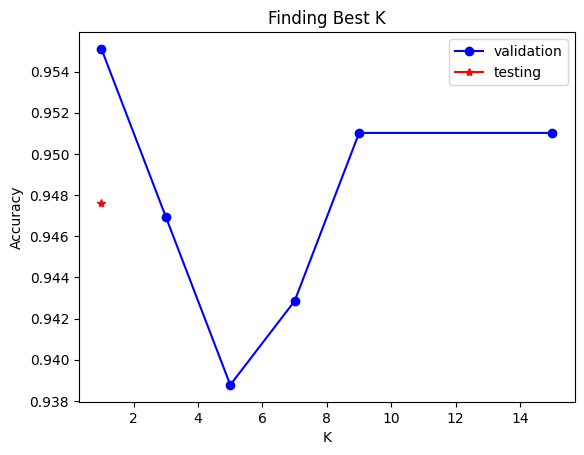

In [16]:
#isabella
x_trainVal, x_Val, y_trainVal, y_Val = train_test_split( x_train, y_train, test_size=0.5)

testKs = [1,3,5,7,9,15]
KVals=np.zeros(shape=(len(testKs),1))
KValsAcc=np.zeros(shape=(len(testKs),1))

n=0
for k in testKs:
  knn = KNN() # create a KNN object (OOP)
  knn.fit(x_trainVal, y_trainVal)
  predictions,probs,knns = knn.predict(x_Val,k)
  predictions = np.array(predictions)
  accuracy = np.sum(predictions==y_Val)/y_Val.shape[0]
  KVals[n] = k
  KValsAcc[n] = accuracy
  n+= 1

# use the best K to predict test data
max = np.amax(KValsAcc)
maxK = np.where(KValsAcc==max)
bestK = int(KVals[maxK])


# validate
knn = KNN()
testPred,probs,knns = knn.fit(x_train, y_train).predict(x_test,bestK)
testPred = np.array(testPred)
y_test = np.array(y_test)
test_accuracy = np.sum(testPred == y_test)/y_test.shape[0]

plt.plot(KVals, KValsAcc, marker='o', color='blue', label='validation')
plt.plot(bestK, test_accuracy, marker='*', color='red', label='testing')
plt.title("Finding Best K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('bestk.png',dpi=300,bbox_inches='tight')

implement KNN using bestK

In [17]:
#isabella
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

model = KNN()
model.fit(x_train,y_train)

predictions, probabilities, knns = model.predict(x_test,bestK)



determine which observations are correctly/incorrectly predicted

In [18]:
#isabella
predictions = np.array(predictions)
y_test = np.array(y_test)

#boolean array for true/false predictions
correct = y_test == predictions
incorrect = np.logical_not(correct)

print(evaluateAcc(predictions,y_test)) #use our evaluateAcc function



0.8523809523809524
None


plot model performance

(210, 1)
(210, 1)


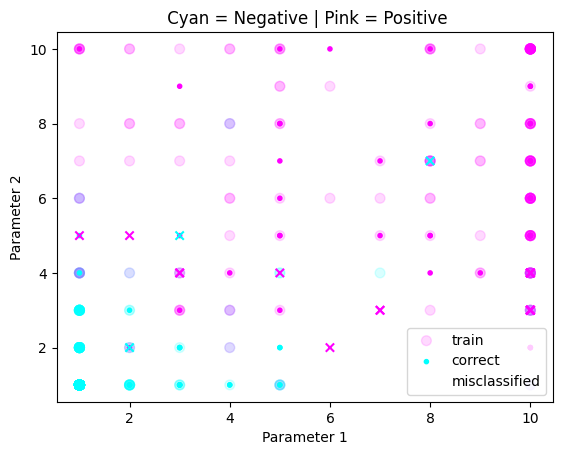

In [19]:
#isabella
factor1 = x_test[:,0:1]
factor2 = x_test[:,1:2]
y_test = pd.DataFrame(y_test)

print(correct.shape)
print(factor1.shape)



#visualization of the points
plt.figure()
plt.title(" Cyan = Negative | Pink = Positive")  # on the cool description, pink is on the right, hence the bigger number.
plt.scatter(x_train[:,0]      , x_train[:,1], s = 50, marker='o'  , c= y_train   , alpha=.15 , cmap = 'cool', label='train')
plt.scatter(factor1[correct]  , factor2[correct]    , marker='.'  , c= predictions[correct]  , cmap = 'cool',  label='correct')
plt.scatter(factor1[incorrect], factor2[incorrect]  , marker='x'  , c= y_test[incorrect]     , cmap = 'cool', label='misclassified')
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.legend()
plt.show()



Implement Decision Tree

In [20]:
#----------------------------------------- START OF RIDWANUR CODE. DECISION TREE IMPLEMENTATION. ----------------------
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node

In [21]:
#greedy algorithm to choose best attribute
def greedy_test(node, cost_entropy):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_entropy(node.labels[left_indices])
            right_cost = cost_entropy(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [22]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [23]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum depth for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination

    # Preprocessed function declaration. See assignment after definition.
    def fit(self, data, labels):
        pass

    def predict(self, data_test):
        pass

    def _fit_tree(self, node):
      pass

In [24]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = len(np.unique(labels))
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self



def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right





DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [25]:
def predict(self, data_test):
    num_samples = data_test.shape[0]
    unique_classes = np.unique(self.labels)
    num_classes = len(unique_classes)
    predictions = np.zeros(num_samples, dtype=int)
    probabilities = np.zeros((num_samples, num_classes))

    for i, x in enumerate(data_test):
        node = self.root
        depth = 0

        while node.left and (self.max_depth is None or depth < self.max_depth):
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
            depth += 1

        # Mapping the class probabilities assuming they are in the same order as unique_classes
        prob_distribution = node.class_prob
        if len(prob_distribution) == num_classes:
            probabilities[i, :] = prob_distribution
        else:
            # Handle cases where some classes might be missing in the node
            for j, cls in enumerate(unique_classes):
                if cls < len(prob_distribution):
                    probabilities[i, j] = prob_distribution[cls]

        predictions[i] = unique_classes[np.argmax(probabilities[i, :])]

    return predictions, probabilities


DecisionTree.predict = predict

In [26]:
#------------------------------ START OF FRANCOIS CODE: DOING DT DATA ANALYSIS USING IMPLEMENTATION -------------------------

class HyperParamDT: #Could save bestTree and then we can save a bit of performance as it's one less training, but who cares. Too much refactoring is productivity issue.
  def __init__(self):
    self.costFunction = None
    self.maxDepth = None
    self.missClassificationRate = 1

  def __str__(self):
    s = "costFunction:           "    +   str(self.costFunction.__name__)   +   "\n"
    s+= "maxDepth:               "    +   str(self.maxDepth)                +   "\n"
    s+= "missClassificationRate: "    +   str(self.missClassificationRate)  +   "\n"
    return s

def prettyRound(x , numberOfDecimal):
  y = round(x, numberOfDecimal)
  z = str(y).split(".")
  z[1] += "0"*( numberOfDecimal -len(z[1]) )
  return(".".join(z))


def first_neg(list): #find the index of the first negative element in list
    for i, number in enumerate(list):
        if number < 0:
            return i

def first_pos(list):
    for i, number in enumerate(list):
        if number > 0:
            return i

def firstElement_1(x):
  if x.size == 0:
    return -1
  else:
     return x[0]


def firstElement_2(array,x):
  if x == -1:
    return 0
  else:
    return array[x]


In [27]:
def checkModel(modelTree, x_check, y_check, print_result = False):
    #--------------ing the model performance ----------------------
    Prediction, Probabilities = modelTree.predict(x_check)


    ClassificationErrors = np.nonzero( Prediction - y_check  )[0]   #[0] is due to a quirk of np.nonzero outputing: [output] rather then: output , for dim 1 array.
    NumberOfClassificationError = len( ClassificationErrors )
    MissClassificationRate = NumberOfClassificationError / len ( y_check)

    unique_Val, counts_ = np.unique( y_check, return_counts=True)
    NumberOfNegative, NumberOfPositive = counts_[0], counts_[1]

    UniqueDiff, CountDiff =  np.unique( Prediction - y_check , return_counts=True)
    #---------------------------------Assuming Class Number of Positive case > Class Number of Negative Case. 2 case only.
    fni = np.where (UniqueDiff < 0)[0]
    eqi = np.where (UniqueDiff == 0)[0]    # false negative = fn.... equal, false positive
    fpi = np.where (UniqueDiff > 0)[0]


    NumberOfFN      = firstElement_2( CountDiff , firstElement_1(fpi) )
    NumberOfEqual   = firstElement_2( CountDiff , firstElement_1(eqi) )
    NumberOfFP      = firstElement_2( CountDiff , firstElement_1(fni) )


    FalsePositiveRate = NumberOfFP / NumberOfNegative
    TruePositiveRate = ( NumberOfPositive - NumberOfFP )/ NumberOfPositive


    if print_result == True:
      print("The model has a missclassification rate of: ",MissClassificationRate, "(On the  data)")
      print("The model has a False Positive Rate of : ", FalsePositiveRate, "(On the  data)")
      print("The model has a True Positive Rate of : ", TruePositiveRate, "(On the  data)")

    return MissClassificationRate, FalsePositiveRate, TruePositiveRate


In [28]:
maxDepthArray = [3, 4, 5, 6, 7, 8, 10, 14,18]
functionArray = [cost_misclassification, cost_entropy, cost_gini_index]
functionName  = [ function.__name__ for function in functionArray]

def DT_getBestModel( x_train, y_train, x_validate, y_validate, dimension_of_input = 2, print_start = False, print_end = False):

  if print_start:
    print("\nfunction names:",functionName,"\n")
    print( "xtrain=\n",x_train, "\nytrain=\n", y_train, "\nx_validate=\n", x_validate, "\ny_validate=\n", y_validate,"\n")

    print("_________shape:_____________")
    print("x_train   :", np.shape(x_train)  )
    print("y_train   :", np.shape(y_train)  )
    print("x_validate:", np.shape(x_validate)  )
    print("y_validate:", np.shape(y_validate),"\n\n"  )




  missClassificationRate_dictionary, FPR_dict , TPR_dict  = {}, {}, {}
  bestHyperParam = HyperParamDT()
  bestTree = None
  for costFunction in functionArray:
    missClassificationRate_dictionary[costFunction.__name__] = []
    FPR_dict[costFunction.__name__] = []
    TPR_dict[costFunction.__name__] = []

    for maxDepth in maxDepthArray:
      validationTree = DecisionTree(num_classes= dimension_of_input, max_depth=maxDepth, cost_fn = costFunction )
      validationTree.fit( x_train, y_train)
      missClassificationRate, falsePositiveRate, truePositiveRate = checkModel(validationTree, x_validate, y_validate)

      if missClassificationRate < bestHyperParam.missClassificationRate:
        bestTree = validationTree
        bestHyperParam.missClassificationRate = missClassificationRate
        bestHyperParam.costFunction = costFunction
        bestHyperParam.maxDepth = maxDepth



      missClassificationRate_dictionary[costFunction.__name__].append(missClassificationRate)
      FPR_dict[costFunction.__name__].append(falsePositiveRate)
      TPR_dict[costFunction.__name__].append(truePositiveRate)


  if print_end:
    print("\nHere are the best param:")
    print(bestHyperParam)

    print("MissClassifictionRate Dictionary: ")
    print(missClassificationRate_dictionary)

    print("False positive Rate Dictionary: ")
    print(FPR_dict)

    print("True Positive Rate dictionary: ")
    print(TPR_dict)


  return bestHyperParam, bestTree, missClassificationRate_dictionary, FPR_dict, TPR_dict

In [29]:
#Rerun this part only after rerunning everything to get the 2 thing:
x_trainAndValidate,x_test, y_trainAndValidate, y_test = train_test_split(x,y, test_size=0.3)
x_train, x_validate, y_train, y_validate = train_test_split( x_trainAndValidate, y_trainAndValidate, test_size=0.5)
y_train, y_validate, y_test = y_train.flatten(), y_validate.flatten(), y_test.flatten()



bestHyperParam, bestTree, missClassificationRate_dictionary, FPR_dict, TPR_dict = DT_getBestModel( x_train, y_train, x_validate, y_validate, 2, False, False )
print("\nHere are the best param:")
print(bestHyperParam)


print("\n\n")
testMissClassificationRate, testFalsePositiveRate, testTruePositiveRate = checkModel(bestTree, x_test, y_test, True)


Here are the best param:
costFunction:           cost_entropy
maxDepth:               3
missClassificationRate: 0.0326530612244898




The model has a missclassification rate of:  0.0761904761904762 (On the  data)
The model has a False Positive Rate of :  0.04929577464788732 (On the  data)
The model has a True Positive Rate of :  0.8970588235294118 (On the  data)



Here are the best param:
costFunction:           cost_entropy
maxDepth:               3
missClassificationRate: 0.0326530612244898



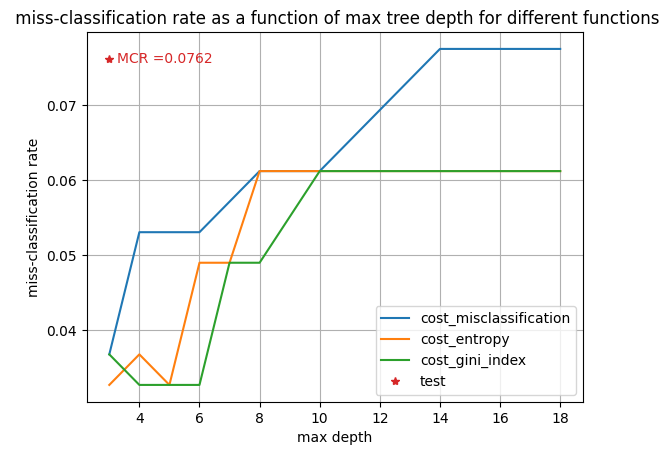

In [30]:
print("\nHere are the best param:")
print(bestHyperParam)


plt.figure()
plt.title(" miss-classification rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel("miss-classification rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , missClassificationRate_dictionary[name], "-" , label = name )


plt.plot(bestHyperParam.maxDepth, testMissClassificationRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testMissClassificationRate, "MCR =" + prettyRound(testMissClassificationRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()


Here are the best param:
costFunction:           cost_entropy
maxDepth:               3
missClassificationRate: 0.0326530612244898



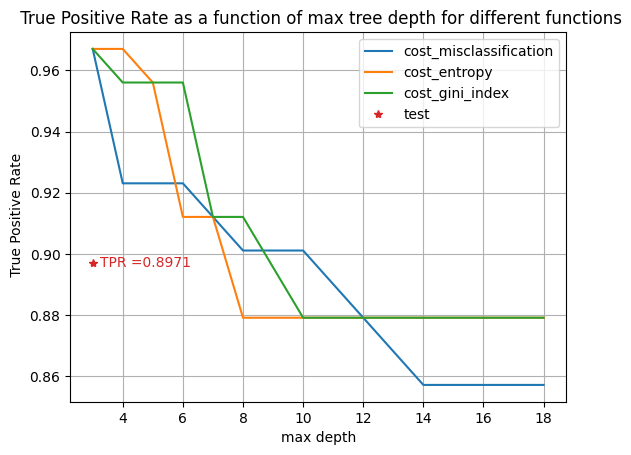

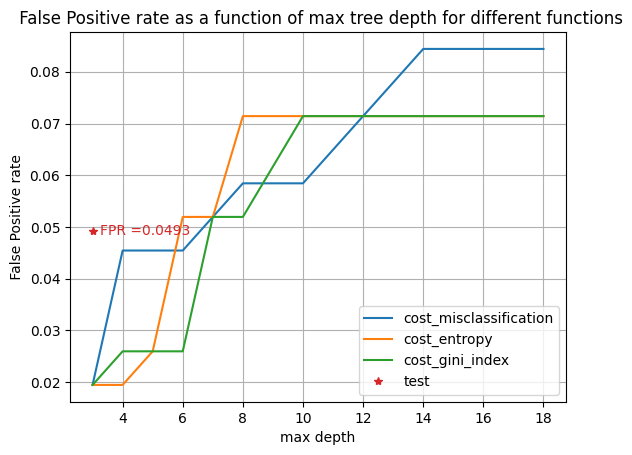

In [31]:
print("\nHere are the best param:")
print(bestHyperParam)

plt.figure()
plt.title(" True Positive Rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" True Positive Rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , TPR_dict[name], "-" , label = name )

plt.plot(bestHyperParam.maxDepth,  testTruePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testTruePositiveRate, "TPR =" + prettyRound(testTruePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()




print("")
##############################





plt.figure()
plt.title(" False Positive rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" False Positive rate ")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray ,  np.array(FPR_dict[name]), "-" , label = name )

plt.plot(bestHyperParam.maxDepth, testFalsePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testFalsePositiveRate, "FPR =" + prettyRound(testFalsePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()

Check DT accuracy

In [32]:
#isabella

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

bestTree = DecisionTree(num_classes= 2, max_depth= bestHyperParam.maxDepth, cost_fn = bestHyperParam.costFunction )

bestTree.fit(x_train, y_train.flatten())

testPrediction, testProbabilities = bestTree.predict(x_test)

testPrediction = pd.DataFrame(testPrediction)
y_test = pd.DataFrame(y_test)
print(evaluateAcc(testPrediction,y_test)) #use our evaluateAcc function


0    0.947619
dtype: float64
None


Implement five-fold cross validation

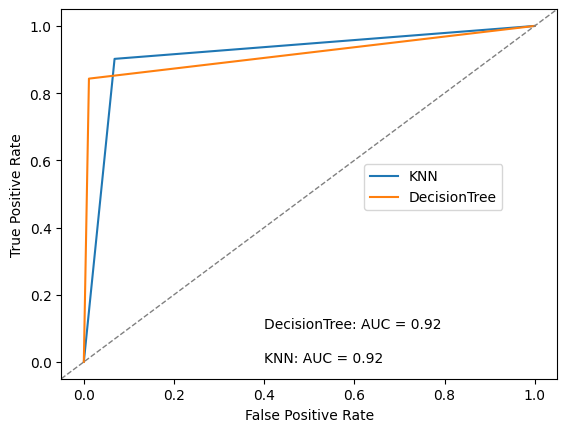

In [33]:
#isabella

x,y = np.array(x), np.array(y)
x = x.astype(int)
y = y.astype(int)

performance = {}

model = KNN()
label,pred = cross_validateKNN(model, x, y)
fpr, tpr, _ = roc_curve(label, pred) # We need a pos label change. Which is the
auc = roc_auc_score(label, pred)
performance["KNN"] = {'fpr':fpr,'tpr':tpr,'auc':auc}


model = DecisionTree()
label,pred = cross_validateDT(model, x, y)
fpr, tpr, _ = roc_curve(label, pred)
auc = roc_auc_score(label, pred)
performance["DecisionTree"] = {'fpr':fpr,'tpr':tpr,'auc':auc}


fig = plt.figure()

import matplotlib.pyplot as plt

i = 0
for model_name, model_perf in performance.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],
             label=model_name)
    plt.text(0.4, i, model_name + ': AUC = '+
             str(round(model_perf['auc'],2)))
    i += 0.1

plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('roc_compareBancer.png', bbox_inches='tight', dpi=300)



plot PRC curve

Text(0.7, 0.3, 'AUC: 0.95')

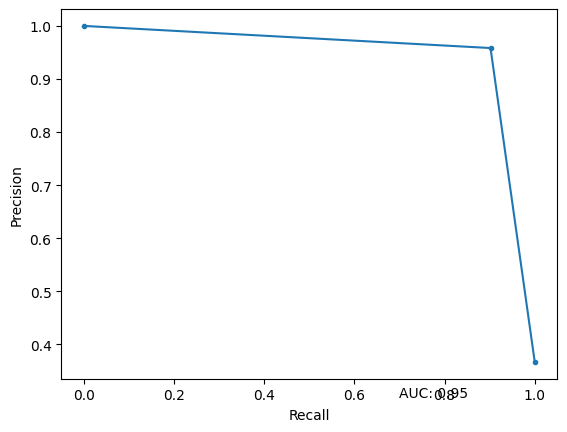

In [34]:
#isabella
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

model = KNN()
label,pred = cross_validateKNN(model, x, y)
fpr, tpr, _ = roc_curve(label, pred) # We need a pos label change. Which is the
auc = roc_auc_score(label, pred)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(label, pred) # 4 = has cancer ? --- question from francois // 2024-01-30 : 4:29 pm
auprc = auc(recall, precision)  # # Francois question: Auc is a float64? can't use it as a function. ANSWER we were missing an import. not it works

perf = {'fpr':fpr,'tpr':tpr,'auroc':auc,
                            'precision':precision,'recall':recall,'auprc':auprc}

plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.text(0.7, 0.3, 'AUC: '+str(round(auprc,2)))




In [35]:
#back to francois

data = dataCopy ############################################################ CHANGE IT HERE TOO!!!
data  = pd.DataFrame(data)


# x y split for decision tree - on unscaled data, DT not sensitive to scale of data

data = data.drop(['id'], axis=1) # remove the id column. Not needed.
x = data.drop(['class'], axis=1) #all variables except response
y = data[[response]] #response only


x,y = np.array(x), np.array(y)
x = x.astype(int)
y = y.astype(int).flatten()



x_trainAndValidate, x_test, y_trainAndValidate, y_test = train_test_split( x, y, test_size=0.3)
x_train, x_validate, y_train, y_validate = train_test_split( x_trainAndValidate, y_trainAndValidate, test_size=0.5)
y_train, y_validate, y_test = y_train.flatten(), y_validate.flatten(), y_test.flatten()

# ----------- the data is now -----------------------
# x_train, y_train
# x_validate, y_validate
# x_test, y_test.


bestHyperParam, bestTree, missClassificationRate_dictionary, FPR_dict, TPR_dict = DT_getBestModel( x_train, y_train, x_validate, y_validate, 9, True )
print("\n\n")
testMissClassificationRate, testFalsePositiveRate, testTruePositiveRate = checkModel(bestTree, x_test, y_test, True)




function names: ['cost_misclassification', 'cost_entropy', 'cost_gini_index'] 

xtrain=
 [[ 8 10 10 ...  9  7  1]
 [ 3  1  1 ...  3  1  1]
 [10  3  4 ...  4  1  1]
 ...
 [ 2  1  1 ...  1  1  1]
 [ 5  1  1 ...  3  1  1]
 [10  4  5 ...  4  1  1]] 
ytrain=
 [1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1] 
x_validate=
 [[ 7  4  7 ...  7  6  1]
 [ 1  1  1 ...  3  1  1]
 [ 5 10 10 ...  6  5  2]
 ...
 [10  3  5 ...  3  5  3]
 [10  8 10 ...  3  1 10]
 [ 1  1  1 ...  3  1  1]] 
y_validate=
 [1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1


Here are the best param:
costFunction:           cost_entropy
maxDepth:               3
missClassificationRate: 0.04897959183673469



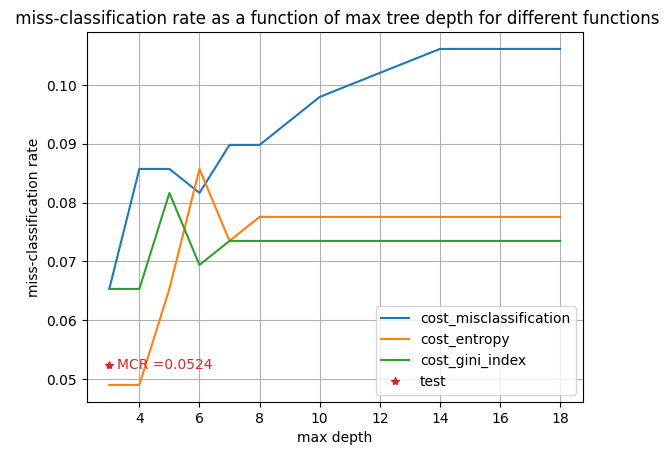

In [36]:
print("\nHere are the best param:")
print(bestHyperParam)


plt.figure()
plt.title(" miss-classification rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel("miss-classification rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , missClassificationRate_dictionary[name], "-" , label = name )


plt.plot(bestHyperParam.maxDepth, testMissClassificationRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testMissClassificationRate, "MCR =" + prettyRound(testMissClassificationRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()


Here are the best param:
costFunction:           cost_entropy
maxDepth:               3
missClassificationRate: 0.04897959183673469



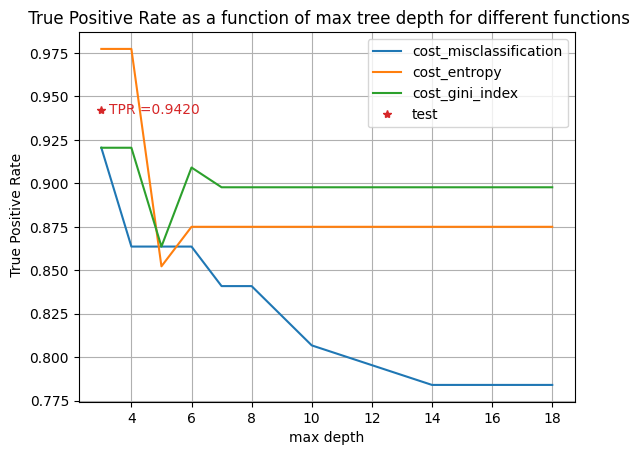

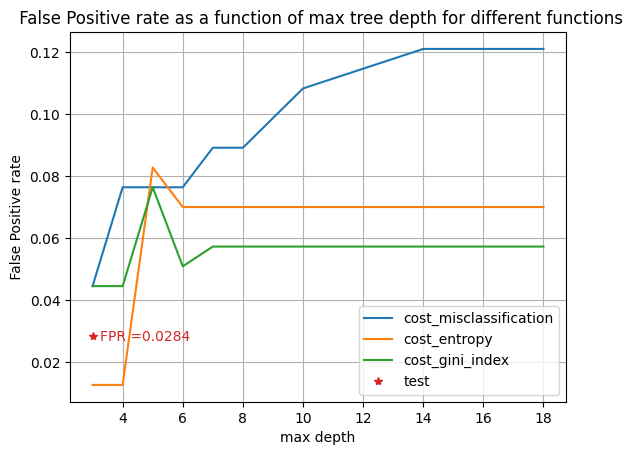

In [37]:
print("\nHere are the best param:")
print(bestHyperParam)

plt.figure()
plt.title(" True Positive Rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" True Positive Rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , TPR_dict[name], "-" , label = name )

plt.plot(bestHyperParam.maxDepth,  testTruePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testTruePositiveRate, "TPR =" + prettyRound(testTruePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()




print("")
##############################





plt.figure()
plt.title(" False Positive rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" False Positive rate ")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray ,  np.array(FPR_dict[name]), "-" , label = name )

plt.plot(bestHyperParam.maxDepth, testFalsePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testFalsePositiveRate, "FPR =" + prettyRound(testFalsePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()

In [38]:
###############################################################################################################################################################################################################
###############################################################################################################################################################################################################
###############################################################################################################################################################################################################


########################################################################### EXPERIMENTING WITH THE NHANES DATASET STARTS HERE #################################################################################


###############################################################################################################################################################################################################
###############################################################################################################################################################################################################
###############################################################################################################################################################################################################

Select the NHANES dataset to work with it

In [39]:
#isabella

data = NHANESdata
dataCopy = copy.deepcopy(data)
response = 'age_group' #set response. for NHANES it is 'age_group' for breastCancer it is 'class'

print("data type:",type(data))

print(data.describe,"\n") #overview of data
print(data.head(10))

data type: <class 'pandas.core.frame.DataFrame'>
<bound method NDFrame.describe of          SEQN  age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0     73564.0          0      61.0       2.0     2.0    35.7   110.0     2.0   150.0  14.91
1     73568.0          0      26.0       2.0     2.0    20.3    89.0     2.0    80.0   3.85
2     73576.0          0      16.0       1.0     2.0    23.2    89.0     2.0    68.0   6.14
3     73577.0          0      32.0       1.0     2.0    28.9   104.0     2.0    84.0  16.15
4     73580.0          0      38.0       2.0     1.0    35.9   103.0     2.0    81.0  10.92
...       ...        ...       ...       ...     ...     ...     ...     ...     ...    ...
2273  83711.0          0      38.0       2.0     2.0    33.5   100.0     2.0    73.0   6.53
2274  83712.0          0      61.0       1.0     2.0    30.0    93.0     2.0   208.0  13.02
2275  83713.0          0      34.0       1.0     2.0    23.7   103.0     2.0   124.0  21.

Impute missing points labeled '?'

In [40]:
#isabella

missing = data.isnull().sum

data[[]] = data[[]].replace('?',nan)

data.fillna(data.mean())

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,0,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,0,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,0,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,0,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,0,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92
...,...,...,...,...,...,...,...,...,...,...
2273,83711.0,0,38.0,2.0,2.0,33.5,100.0,2.0,73.0,6.53
2274,83712.0,0,61.0,1.0,2.0,30.0,93.0,2.0,208.0,13.02
2275,83713.0,0,34.0,1.0,2.0,23.7,103.0,2.0,124.0,21.41
2276,83718.0,0,60.0,2.0,2.0,27.4,90.0,2.0,108.0,4.99


Observe scale of all predictors

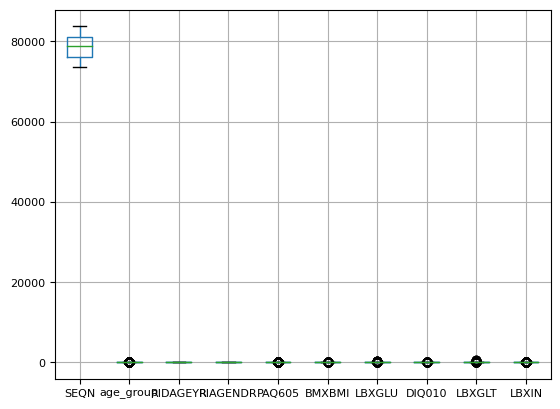

In [41]:
#isabella

#observe scale of all predictors

boxplot = data.boxplot(fontsize=8)

Calculate parameter means, variances, correlations with label

In [42]:
#isabella

# analyze predictors

corr = data.corr()
responseCor = pd.DataFrame((corr[[response]])) #for NHANES column is age group, for breastCancer, column is class

params = list(data.columns.values)

means=[]
var=[]

for param in params: #get mean of each column
    val = data[param].mean()
    means.append(val)
means = pd.DataFrame(means)
names = list(responseCor.index)
means.index = names

var=[]
for param in params: #get mean of each column
    val = data[param].var()
    var.append(val)
var = pd.DataFrame(var)
names = list(responseCor.index)
var.index = names

responseCor.columns = ['corr']
responseCor = responseCor.sort_values(by = ['corr'])
print(responseCor)

               corr
LBXIN     -0.064159
BMXBMI    -0.004147
RIAGENDR  -0.002767
SEQN       0.018257
DIQ010     0.026399
PAQ605     0.094789
LBXGLU     0.116462
LBXGLT     0.243113
RIDAGEYR   0.684490
age_group  1.000000


Choose the two most important factors based on correlation with label

In [43]:
#isabella

corIndices = responseCor.index
impFact1 = corIndices[-2] #select the factors that correlated best with the label
impFact2 = corIndices[-3]

print(impFact1)
print(impFact2)

RIDAGEYR
LBXGLT


Re-scale parameters if needed

In [44]:
#isabella

#if we need to rescale predictors

df = data.drop(impFact1,axis=1) #put factors on the same scale
df_norm = (df-df.min())/(df.max()-df.min())                                                # francois: / df.std ?
df_norm = pd.concat((df_norm, data.RIDAGEYR), 1) #update feature name

df1 = df_norm.drop(impFact2,axis=1)
df_norm1 = (df1-df1.min())/(df1.max()-df1.min())
df_norm1 = pd.concat((df_norm1, df_norm.LBXGLT), 1) #update feature name

df_norm1 = df_norm1.sample(frac=1) #shuffle data
print(df_norm1.head())

          SEQN  age_group  RIAGENDR    PAQ605    BMXBMI    LBXGLU  DIQ010     LBXIN  RIDAGEYR  \
2180  0.955623        0.0       0.0  0.000000  0.174460  0.105263     0.5  0.051591  0.338235   
248   0.111975        1.0       0.0  0.166667  0.339928  0.157895     0.5  0.396280  0.823529   
329   0.150940        0.0       0.0  0.000000  0.330935  0.090643     0.5  0.185022  0.191176   
1404  0.634262        0.0       0.0  0.166667  0.188849  0.049708     0.5  0.052374  0.397059   
514   0.232117        1.0       0.0  0.166667  0.188849  0.105263     0.5  0.066079  1.000000   

        LBXGLT  
2180  0.097518  
248   0.235816  
329   0.042553  
1404  0.101064  
514   0.166667  


<ipython-input-44-dbbffece04f9>:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_norm = pd.concat((df_norm, data.RIDAGEYR), 1) #update feature name
<ipython-input-44-dbbffece04f9>:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_norm1 = pd.concat((df_norm1, df_norm.LBXGLT), 1) #update feature name


x, y split

In [45]:
#isabella

# x y split on scaled factors

x, y = df_norm1[['RIDAGEYR','LBXGLT']], df_norm1[[response]]#slices columns most correlated with response variable

x,y = np.array(x), np.array(y)
x = x.astype(int)
y = y.astype(int)

In [46]:
#isabella

# x y split on non-scaled data (if scaling is not required)

x, y = data[[impFact1,impFact2]], data[[response]]#slices columns most correlated with response variable

x,y = np.array(x), np.array(y)

Train, test split and plot data

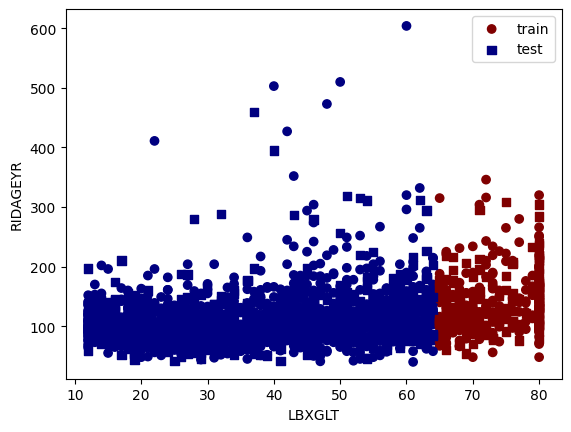

In [47]:
#isabella

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

#visualization of the data
plt.figure()
plt.xlabel(impFact2)
plt.ylabel(impFact1)

plt.scatter(x_train[:,0], x_train[:,1], c = y_train,cmap=plt.cm.jet, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c= y_test,cmap=plt.cm.jet, marker='s', label='test')

plt.legend()
plt.show()

KNN MODEL:


Define distance and accuracy functions

In [48]:
#isabella

# Distance functions

def euclidian(x1,x2):
  return(np.sqrt(np.sum((x1 - x2)**2, axis=-1)))

def manhattan(x1, x2):
  return(np.sum(abs(x1 - x2)))

Define evaluation functions

In [49]:
#evaluate eccuracy

def evaluateAcc(true,predicted):

  accuracy = np.sum(predicted == true)/true.shape[0]
  print(accuracy)

#k-fold DT

def cross_validateDT(model, X_input, Y_output):
  kf = KFold(n_splits=5,random_state=1,shuffle=True)
  trueLabels = np.array([0] * X_input.shape[0])
  pred_scores = np.array([0.0]*X_input.shape[0])
  for train_index, test_index in kf.split(X_input):
    Y_output = Y_output.flatten()
    model.fit(X_input[train_index], Y_output[train_index])
    trueLabels = Y_output[test_index]
    prediction, probabilities = model.predict(X_input[test_index])
    probability = np.array(probabilities)
  return trueLabels, prediction

#k-fold KNN
def cross_validateKNN(model, X_input, Y_output):
   kf = KFold(n_splits=5,random_state=1,shuffle=True)
   trueLabels = np.array([0] * X_input.shape[0])
   pred_scores = np.array([0.0]*X_input.shape[0])
   for train_index, test_index in kf.split(X_input):
    model.fit(X_input[train_index], Y_output[train_index])
    trueLabels = Y_output[test_index]
    prediction,probability,knns = model.predict(X_input[test_index], bestK) #myK -> bestK // francois 2024-01-30, 15:35
    probability = np.array(probability)
   return trueLabels, probability

Define KNN model

In [50]:
#isabella
#Implement KNN

class KNN:

  def __init__(self):
      return

  def fit(self,x,y):
    self.x = x
    self.y = y
    self.C = np.max(y) + 1
    return self


  def predict(self, x_test,K,dist_fn=euclidian):
    numTest = x_test.shape[0]
    numTrain = x_train.shape[0]
    outputs = np.unique(y_train)
    predictions = []
    probabilities = []
    neighbors = []

    for val in range(1,numTest+1):
      x1 = x_test[(val-1):val,0:2] # takes test samples one by one
      distances = np.zeros(shape = (numTrain,1)) #empty list for this sample's distances
      probs = np.zeros(len(outputs)) #will calculate probability for each possible label
      for i in range(1,numTrain+1):
        x2 = x_train[i-1:i,0:2] # takes 1,2,...,n training samples
        newDist = np.array(dist_fn(x1,x2)) #calculate distance for i sample
        distances[i-1] = newDist #collect distance for sample i
      checkLabels = np.concatenate((x_train,y_train,np.array(distances)),axis=1)
      checkLabels = pd.DataFrame(checkLabels)
      checkLabels.columns = ['x1','x1','label','dist']
      knns = checkLabels.sort_values(by="dist",ascending=True).iloc[:K] # sort and pull k nearest neighbors
      neighbors.append(knns) # will return knns for each test point
      prediction = knns['label'].mode()
      prob = (knns['label'].mode().sum())/K
      predictions.append(prediction)
      probabilities.append(prob)

    return predictions, probabilities, neighbors

Choose best k and plot

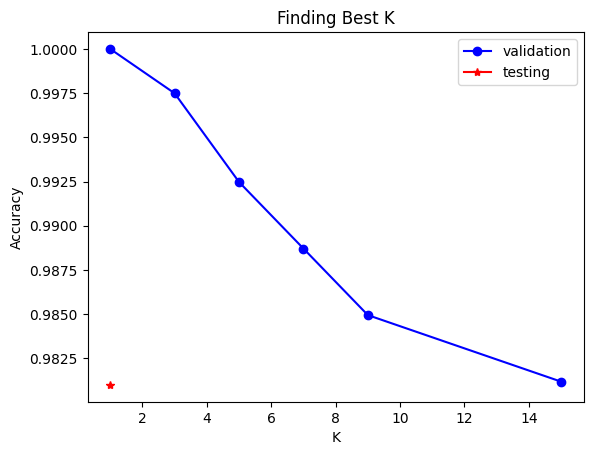

In [51]:
#isabella
x_trainVal, x_Val, y_trainVal, y_Val = train_test_split( x_train, y_train, test_size=0.5)

testKs = [1,3,5,7,9,15]
KVals=np.zeros(shape=(len(testKs),1))
KValsAcc=np.zeros(shape=(len(testKs),1))

n=0
for k in testKs:
  knn = KNN() # create a KNN object (OOP)
  knn.fit(x_trainVal, y_trainVal)
  predictions,probs,knns = knn.predict(x_Val,k)
  predictions = np.array(predictions)
  accuracy = np.sum(predictions==y_Val)/y_Val.shape[0]
  KVals[n] = k
  KValsAcc[n] = accuracy
  n+= 1

# use the best K to predict test data
max = np.amax(KValsAcc)
maxK = np.where(KValsAcc==max)
# Find the index of the maximum accuracy
max_index = np.argmax(KValsAcc)
# Use this index to find the corresponding value of K
bestK = int(KVals[max_index])



# validate
knn = KNN()
testPred,probs,knns = knn.fit(x_train, y_train).predict(x_test,bestK)
testPred = np.array(testPred)
y_test = np.array(y_test)
test_accuracy = np.sum(testPred == y_test)/y_test.shape[0]

plt.plot(KVals, KValsAcc, marker='o', color='blue', label='validation')
plt.plot(bestK, test_accuracy, marker='*', color='red', label='testing')
plt.title("Finding Best K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('bestk.png',dpi=300,bbox_inches='tight')

Implement KNN using bestK

In [52]:
#isabella
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

model = KNN()
model.fit(x_train,y_train)

predictions, probabilities, knns = model.predict(x_test,bestK)

Determine which observations are correctly/incorrectly predicted

In [53]:
#isabella
predictions = np.array(predictions)
y_test = np.array(y_test)

#boolean array for true/false predictions
correct = y_test == predictions
incorrect = np.logical_not(correct)

print(evaluateAcc(predictions,y_test)) #use our evaluateAcc function

0.9926900584795322
None


Plot model performance

(684, 1)
(684, 1)


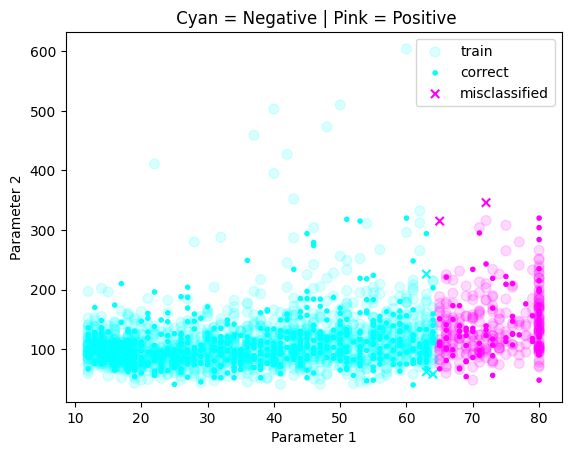

In [54]:
#isabella
factor1 = x_test[:,0:1]
factor2 = x_test[:,1:2]
y_test = pd.DataFrame(y_test)

print(correct.shape)
print(factor1.shape)



#visualization of the points
plt.figure()
plt.title(" Cyan = Negative | Pink = Positive")  # on the cool description, pink is on the right, hence the bigger number.
plt.scatter(x_train[:,0]      , x_train[:,1], s = 50, marker='o'  , c= y_train   , alpha=.15 , cmap = 'cool', label='train')
plt.scatter(factor1[correct]  , factor2[correct]    , marker='.'  , c= predictions[correct]  , cmap = 'cool',  label='correct')
plt.scatter(factor1[incorrect], factor2[incorrect]  , marker='x'  , c= y_test[incorrect]     , cmap = 'cool', label='misclassified')
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.legend()
plt.show()

Implement Decision Tree

In [55]:
#----------------------------------------- START OF RIDWANUR CODE. DECISION TREE IMPLEMENTATION. ----------------------
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node

In [56]:
#greedy algorithm to choose best attribute
def greedy_test(node, cost_entropy):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_entropy(node.labels[left_indices])
            right_cost = cost_entropy(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [57]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [58]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum depth for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination

    # Preprocessed function declaration. See assignment after definition.
    def fit(self, data, labels):
        pass

    def predict(self, data_test):
        pass

    def _fit_tree(self, node):
      pass
      # So we remember this one exist too.

In [59]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = len(np.unique(labels))
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self



def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right





DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

In [60]:
def predict(self, data_test):
    num_samples = data_test.shape[0]
    unique_classes = np.unique(self.labels)
    num_classes = len(unique_classes)
    predictions = np.zeros(num_samples, dtype=int)
    probabilities = np.zeros((num_samples, num_classes))

    for i, x in enumerate(data_test):
        node = self.root
        depth = 0

        while node.left and (self.max_depth is None or depth < self.max_depth):
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
            depth += 1

        # Mapping the class probabilities assuming they are in the same order as unique_classes
        prob_distribution = node.class_prob
        if len(prob_distribution) == num_classes:
            probabilities[i, :] = prob_distribution
        else:
            # Handle cases where some classes might be missing in the node
            for j, cls in enumerate(unique_classes):
                if cls < len(prob_distribution):
                    probabilities[i, j] = prob_distribution[cls]

        predictions[i] = unique_classes[np.argmax(probabilities[i, :])]

    return predictions, probabilities


DecisionTree.predict = predict

In [61]:
#------------------------------ START OF FRANCOIS CODE: DOING DT DATA ANALYSIS USING IMPLEMENTATION -------------------------

class HyperParamDT: #Could save bestTree and then we can save a bit of performance as it's one less training, but who cares. Too much refactoring is productivity issue.
  def __init__(self):
    self.costFunction = None
    self.maxDepth = None
    self.missClassificationRate = 1

  def __str__(self):
    s = "costFunction:           "    +   str(self.costFunction.__name__)   +   "\n"
    s+= "maxDepth:               "    +   str(self.maxDepth)                +   "\n"
    s+= "missClassificationRate: "    +   str(self.missClassificationRate)  +   "\n"
    return s

def prettyRound(x , numberOfDecimal):
  y = round(x, numberOfDecimal)
  z = str(y).split(".")
  z[1] += "0"*( numberOfDecimal -len(z[1]) )
  return(".".join(z))


def first_neg(list): #find the index of the first negative element in list
    for i, number in enumerate(list):
        if number < 0:
            return i

def first_pos(list):
    for i, number in enumerate(list):
        if number > 0:
            return i

def firstElement_1(x):
  if x.size == 0:
    return -1
  else:
     return x[0]


def firstElement_2(array,x):
  if x == -1:
    return 0
  else:
    return array[x]

In [62]:
def checkModel(modelTree, x_check, y_check, print_result = False):
    #--------------ing the model performance ----------------------
    Prediction, Probabilities = modelTree.predict(x_check)


    ClassificationErrors = np.nonzero( Prediction - y_check  )[0]   #[0] is due to a quirk of np.nonzero outputing: [output] rather then: output , for dim 1 array.
    NumberOfClassificationError = len( ClassificationErrors )
    MissClassificationRate = NumberOfClassificationError / len ( y_check)

    unique_Val, counts_ = np.unique( y_check, return_counts=True)
    NumberOfNegative, NumberOfPositive = counts_[0], counts_[1]

    UniqueDiff, CountDiff =  np.unique( Prediction - y_check , return_counts=True)
    #---------------------------------Assuming Class Number of Positive case > Class Number of Negative Case. 2 case only.
    fni = np.where (UniqueDiff < 0)[0]
    eqi = np.where (UniqueDiff == 0)[0]    # false negative = fn.... equal, false positive
    fpi = np.where (UniqueDiff > 0)[0]


    NumberOfFN      = firstElement_2( CountDiff , firstElement_1(fpi) )
    NumberOfEqual   = firstElement_2( CountDiff , firstElement_1(eqi) )
    NumberOfFP      = firstElement_2( CountDiff , firstElement_1(fni) )
    #feel free to rename those fukcing.



    #print(fni, eqi, fpi, "| ", NumberOfFN, NumberOfEqual, NumberOfFP) #if it print it might lead to a bug, idk? [] should -> 0



    FalsePositiveRate = NumberOfFP / NumberOfNegative
    TruePositiveRate = ( NumberOfPositive - NumberOfFP )/ NumberOfPositive
    #double check this.



    if print_result == True:
      print("The model has a missclassification rate of: ",MissClassificationRate, "(On the  data)")
      print("The model has a False Positive Rate of : ", FalsePositiveRate, "(On the  data)")
      print("The model has a True Positive Rate of : ", TruePositiveRate, "(On the  data)")

    return MissClassificationRate, FalsePositiveRate, TruePositiveRate

In [63]:
maxDepthArray = [3, 4, 5, 6, 7, 8, 10, 14,18]
functionArray = [cost_misclassification, cost_entropy, cost_gini_index]
functionName  = [ function.__name__ for function in functionArray]

def DT_getBestModel( x_train, y_train, x_validate, y_validate, dimension_of_input = 2, print_start = False, print_end = False):

  if print_start:
    print("\nfunction names:",functionName,"\n")
    print( "xtrain=\n",x_train, "\nytrain=\n", y_train, "\nx_validate=\n", x_validate, "\ny_validate=\n", y_validate,"\n")

    print("_________shape:_____________")
    print("x_train   :", np.shape(x_train)  )
    print("y_train   :", np.shape(y_train)  )
    print("x_validate:", np.shape(x_validate)  )
    print("y_validate:", np.shape(y_validate),"\n\n"  )




  missClassificationRate_dictionary, FPR_dict , TPR_dict  = {}, {}, {}
  bestHyperParam = HyperParamDT()
  bestTree = None
  for costFunction in functionArray:
    missClassificationRate_dictionary[costFunction.__name__] = []
    FPR_dict[costFunction.__name__] = []
    TPR_dict[costFunction.__name__] = []

    for maxDepth in maxDepthArray:
      validationTree = DecisionTree(num_classes= dimension_of_input, max_depth=maxDepth, cost_fn = costFunction )
      validationTree.fit( x_train, y_train)
      missClassificationRate, falsePositiveRate, truePositiveRate = checkModel(validationTree, x_validate, y_validate)

      if missClassificationRate < bestHyperParam.missClassificationRate:
        bestTree = validationTree
        bestHyperParam.missClassificationRate = missClassificationRate
        bestHyperParam.costFunction = costFunction
        bestHyperParam.maxDepth = maxDepth



      missClassificationRate_dictionary[costFunction.__name__].append(missClassificationRate)
      FPR_dict[costFunction.__name__].append(falsePositiveRate)
      TPR_dict[costFunction.__name__].append(truePositiveRate)


  if print_end:
    print("\nHere are the best param:")
    print(bestHyperParam)

    print("MissClassifictionRate Dictionary: ")
    print(missClassificationRate_dictionary)

    print("False positive Rate Dictionary: ")
    print(FPR_dict)

    print("True Positive Rate dictionary: ")
    print(TPR_dict)


  return bestHyperParam, bestTree, missClassificationRate_dictionary, FPR_dict, TPR_dict

In [64]:
#Rerun this part only after rerunning everything to get the 2 thing:
x_trainAndValidate,x_test, y_trainAndValidate, y_test = train_test_split(x,y, test_size=0.3)
x_train, x_validate, y_train, y_validate = train_test_split( x_trainAndValidate, y_trainAndValidate, test_size=0.5)
y_train, y_validate, y_test = y_train.flatten(), y_validate.flatten(), y_test.flatten()



bestHyperParam, bestTree, missClassificationRate_dictionary, FPR_dict, TPR_dict = DT_getBestModel( x_train, y_train, x_validate, y_validate, 2, False, False )
print("\nHere are the best param:")
print(bestHyperParam)


print("\n\n")
testMissClassificationRate, testFalsePositiveRate, testTruePositiveRate = checkModel(bestTree, x_test, y_test, True)


Here are the best param:
costFunction:           cost_misclassification
maxDepth:               3
missClassificationRate: 0.0




The model has a missclassification rate of:  0.0 (On the  data)
The model has a False Positive Rate of :  0.0 (On the  data)
The model has a True Positive Rate of :  1.0 (On the  data)



Here are the best param:
costFunction:           cost_misclassification
maxDepth:               3
missClassificationRate: 0.0



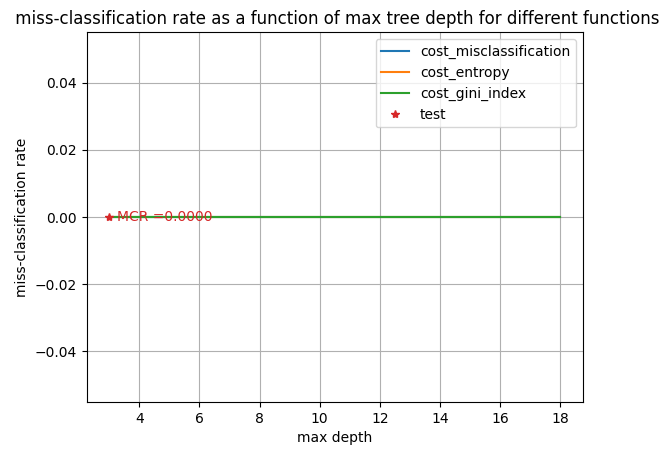

In [65]:
print("\nHere are the best param:")
print(bestHyperParam)


plt.figure()
plt.title(" miss-classification rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel("miss-classification rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , missClassificationRate_dictionary[name], "-" , label = name )


plt.plot(bestHyperParam.maxDepth, testMissClassificationRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testMissClassificationRate, "MCR =" + prettyRound(testMissClassificationRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()


Here are the best param:
costFunction:           cost_misclassification
maxDepth:               3
missClassificationRate: 0.0



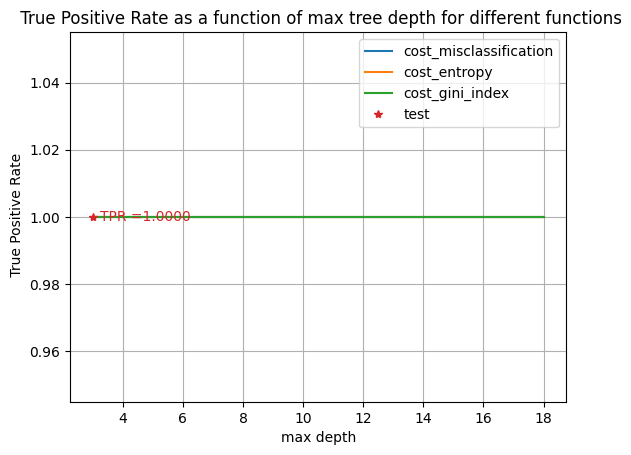

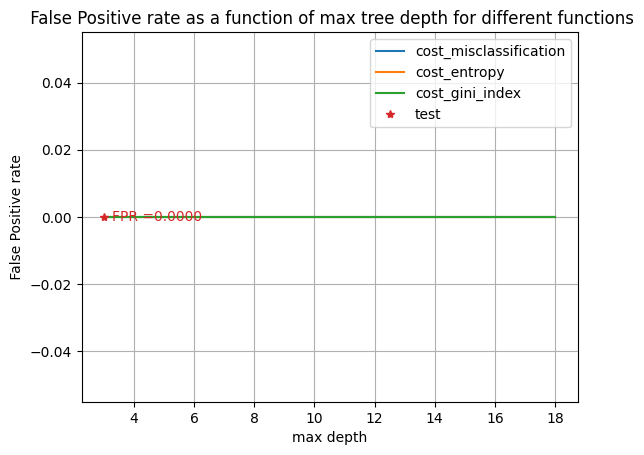

In [66]:
print("\nHere are the best param:")
print(bestHyperParam)

plt.figure()
plt.title(" True Positive Rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" True Positive Rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , TPR_dict[name], "-" , label = name )

plt.plot(bestHyperParam.maxDepth,  testTruePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testTruePositiveRate, "TPR =" + prettyRound(testTruePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()




print("")
##############################





plt.figure()
plt.title(" False Positive rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" False Positive rate ")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray ,  np.array(FPR_dict[name]), "-" , label = name )

plt.plot(bestHyperParam.maxDepth, testFalsePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testFalsePositiveRate, "FPR =" + prettyRound(testFalsePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()

Check DT accuracy

In [67]:
#isabella

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

bestTree = DecisionTree(num_classes= 2, max_depth= bestHyperParam.maxDepth, cost_fn = bestHyperParam.costFunction )

bestTree.fit(x_train, y_train.flatten())

testPrediction, testProbabilities = bestTree.predict(x_test)

testPrediction = pd.DataFrame(testPrediction)
y_test = pd.DataFrame(y_test)
print(evaluateAcc(testPrediction,y_test)) #use our evaluateAcc function

0    1.0
dtype: float64
None


Implement five-fold cross validation

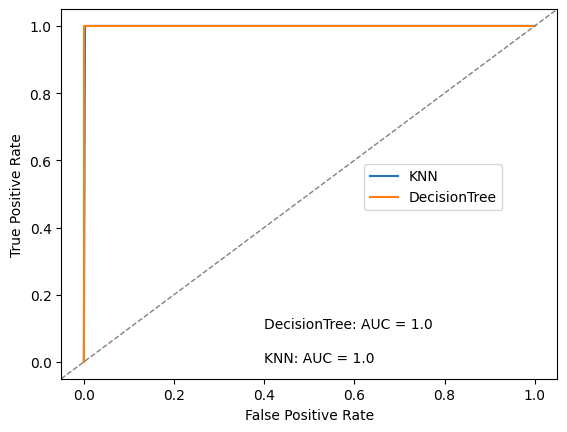

In [68]:
#isabella


x,y = np.array(x), np.array(y)
x = x.astype(int)
y = y.astype(int)

performance = {}

model = KNN()
label,pred = cross_validateKNN(model, x, y)
fpr, tpr, _ = roc_curve(label, pred) # We need a pos label change. Which is the
auc = roc_auc_score(label, pred)
performance["KNN"] = {'fpr':fpr,'tpr':tpr,'auc':auc}


model = DecisionTree()
label,pred = cross_validateDT(model, x, y)
fpr, tpr, _ = roc_curve(label, pred)
auc = roc_auc_score(label, pred)
performance["DecisionTree"] = {'fpr':fpr,'tpr':tpr,'auc':auc}


fig = plt.figure()

import matplotlib.pyplot as plt

i = 0
for model_name, model_perf in performance.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],
             label=model_name)
    plt.text(0.4, i, model_name + ': AUC = '+
             str(round(model_perf['auc'],2)))
    i += 0.1

plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
plt.legend(loc='upper center', bbox_to_anchor=(0.75, 0.6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('roc_compareBancer.png', bbox_inches='tight', dpi=300)

Text(0.7, 0.3, 'AUC: 0.96')

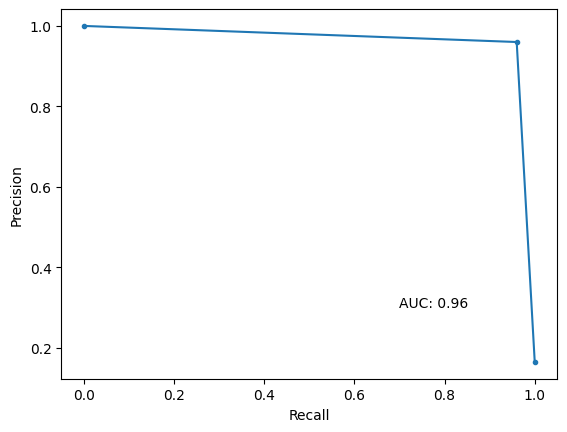

In [69]:
#isabella
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3)

model = KNN()
label,pred = cross_validateKNN(model, x, y)
fpr, tpr, _ = roc_curve(label, pred) # We need a pos label change. Which is the
auc = roc_auc_score(label, pred)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(label, pred) # 4 = has cancer ? --- question from francois // 2024-01-30 : 4:29 pm
auprc = auc(recall, precision)  # # Francois question: Auc is a float64? can't use it as a function. ANSWER we were missing an import. not it works

perf = {'fpr':fpr,'tpr':tpr,'auroc':auc,
                            'precision':precision,'recall':recall,'auprc':auprc}

plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.text(0.7, 0.3, 'AUC: '+str(round(auprc,2)))

In [70]:
#back to francois

data = dataCopy ############################################################ CHANGE IT HERE TOO!!!
data  = pd.DataFrame(data)


# x y split for decision tree - on unscaled data, DT not sensitive to scale of data

#data = data.drop(['id'], axis=1) # remove the id column. Not needed.
x = data.drop(['age_group'], axis=1) #all variables except response
y = data[[response]] #response only


x,y = np.array(x), np.array(y)
x = x.astype(int)
y = y.astype(int).flatten()



x_trainAndValidate, x_test, y_trainAndValidate, y_test = train_test_split( x, y, test_size=0.3)
x_train, x_validate, y_train, y_validate = train_test_split( x_trainAndValidate, y_trainAndValidate, test_size=0.5)
y_train, y_validate, y_test = y_train.flatten(), y_validate.flatten(), y_test.flatten()

# ----------- the data is now -----------------------
# x_train, y_train
# x_validate, y_validate
# x_test, y_test.


bestHyperParam, bestTree, missClassificationRate_dictionary, FPR_dict, TPR_dict = DT_getBestModel( x_train, y_train, x_validate, y_validate, 9, True )
print("\n\n")
testMissClassificationRate, testFalsePositiveRate, testTruePositiveRate = checkModel(bestTree, x_test, y_test, True)


function names: ['cost_misclassification', 'cost_entropy', 'cost_gini_index'] 

xtrain=
 [[74928    50     1 ...     3   121     6]
 [75753    19     1 ...     2    99     4]
 [77365    23     1 ...     2    67     4]
 ...
 [80729    31     1 ...     2    81    22]
 [77151    34     1 ...     2    69     6]
 [75188    35     2 ...     2   103    17]] 
ytrain=
 [0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


Here are the best param:
costFunction:           cost_misclassification
maxDepth:               3
missClassificationRate: 0.0



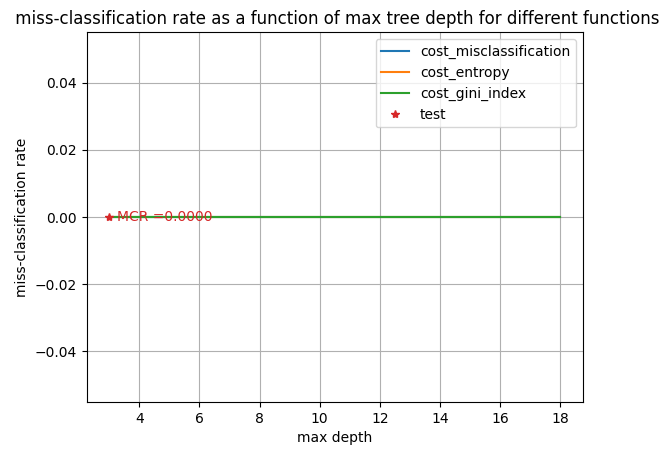

In [71]:
print("\nHere are the best param:")
print(bestHyperParam)


plt.figure()
plt.title(" miss-classification rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel("miss-classification rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , missClassificationRate_dictionary[name], "-" , label = name )


plt.plot(bestHyperParam.maxDepth, testMissClassificationRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testMissClassificationRate, "MCR =" + prettyRound(testMissClassificationRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()


Here are the best param:
costFunction:           cost_misclassification
maxDepth:               3
missClassificationRate: 0.0



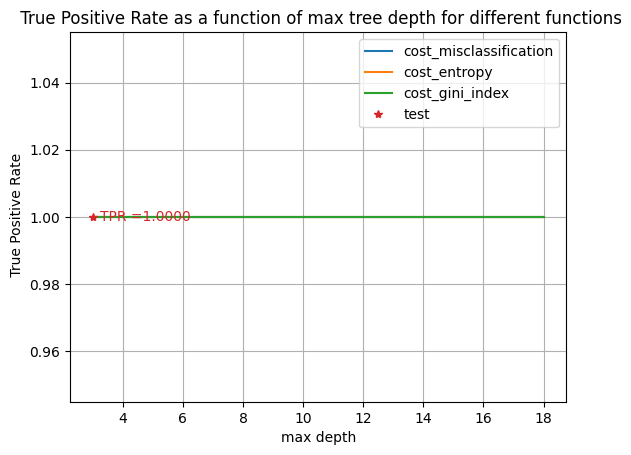

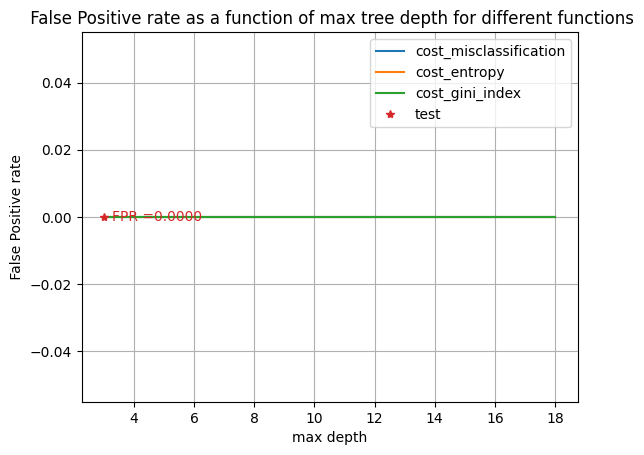

In [72]:
print("\nHere are the best param:")
print(bestHyperParam)

plt.figure()
plt.title(" True Positive Rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" True Positive Rate")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray , TPR_dict[name], "-" , label = name )

plt.plot(bestHyperParam.maxDepth,  testTruePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testTruePositiveRate, "TPR =" + prettyRound(testTruePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()




print("")
##############################





plt.figure()
plt.title(" False Positive rate as a function of max tree depth for different functions")
plt.xlabel("max depth")
plt.ylabel(" False Positive rate ")
plt.grid()

for name in functionName:
  plt.plot( maxDepthArray ,  np.array(FPR_dict[name]), "-" , label = name )

plt.plot(bestHyperParam.maxDepth, testFalsePositiveRate, "*", label = "test" )
plt.text( bestHyperParam.maxDepth + 0.25 , testFalsePositiveRate, "FPR =" + prettyRound(testFalsePositiveRate,4), color = "tab:red", ha="left",va="center")
plt.legend()
plt.show()